#First we should arrange the data into the train and test folders

In [37]:
from pathlib import Path
import os, random
from PIL import Image


DATA_PATH = Path("C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\dataset")
TRAIN_DIR = DATA_PATH / "train"
TEST_DIR = DATA_PATH / "test"
DOWNLOADS_PATH = Path("C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2")
dwd_cow = DOWNLOADS_PATH / "cow"
dwd_cat = DOWNLOADS_PATH / "cat"
dwd_dog = DOWNLOADS_PATH / "dog"
dwd_goat = DOWNLOADS_PATH / "goat"

VALID_IMGS = {
    "cat":[],
    "cow":[],
    "dog":[],
    "goat":[]
} #this is a dictionary for paths for good images among the 4 classes

def clean_data(path):
  
    for img in os.scandir(path):
        
        
        try:
            image = Image.open(img.path)
           
            VALID_IMGS[path.stem].append(img.path)
        except Exception as e: 
            continue 

clean_data(dwd_cat)
clean_data(dwd_cow)
clean_data(dwd_dog)
clean_data(dwd_goat)

print(len(VALID_IMGS))
print(VALID_IMGS.values())

ALL_IMGS = DATA_PATH.glob("*/*/*.jpg")

for dir, dirnames, file in os.walk(TRAIN_DIR):
    print(dir)

test_size = 0.2
for animal in VALID_IMGS.keys():
    test_paths = random.sample(VALID_IMGS[animal], k=int(len(VALID_IMGS[animal])*test_size))
    train_paths = set(VALID_IMGS[animal]) - set(test_paths)

    print(f"{animal}:")
    print(f"\ttest images: {len(test_paths)} ")
    print(f"\ttrain images: {(len(train_paths))} ")

    for i, path in enumerate(train_paths):
        with open(f"{TRAIN_DIR/animal/(str(i) + '.jpg')}", "wb") as f:
            img = Image.open(path)
            img.save(f, "JPEG")

    for j, path in enumerate(test_paths):
        with open(f"{TEST_DIR/animal/(str(j) + '.jpg')}", "wb") as f:
            img = Image.open(path)
            img.save(f, "JPEG")

    


4
dict_values([['C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten0.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten1.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten10.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten101.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten102.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten104.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten105.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten107.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten108.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten109.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desktop\\classification\\downloads2\\cat\\kitten11.jpg', 'C:\\Users\\Bobka\\OneDrive\\Desk

TO-DO LIST
1.Pre-process the images
2.Load the images into a `torch.utils.Data.Dataset`
3.Load the images into a `torch.utils.Data.DataLoader`
4.Train different models , starting with TinyVGG architecture



1.PREPROCESSING THE DATA
 - resizing the images (both train and test)
 - Add Augmentation to training data 
 - Transform into tensors

In [84]:
import torch, numpy as np, matplotlib.pyplot as plt, torchvision
from torchvision import datasets, transforms

RANDOM_SEED = 42

train_transforms = transforms.Compose([
    # resizing the images
    transforms.Resize((64, 64)),

    # random augment
    transforms.TrivialAugmentWide(num_magnitude_bins=10),

    # trasnforming to tensor
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    # resize
    transforms.Resize((64, 64)),

    # to tensors
    transforms.ToTensor()
])


# loading the images to a dataloader
train_data = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms, target_transform=None)
test_data = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms, target_transform=None)


train_data


Dataset ImageFolder
    Number of datapoints: 553
    Root location: C:\Users\Bobka\OneDrive\Desktop\classification\dataset\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               TrivialAugmentWide(num_magnitude_bins=10, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )

169

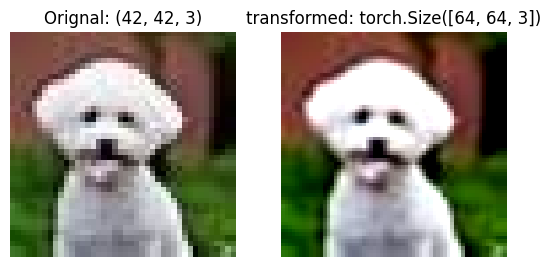

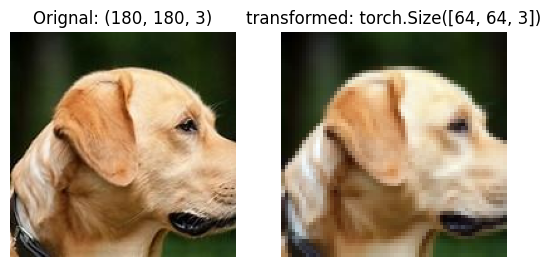

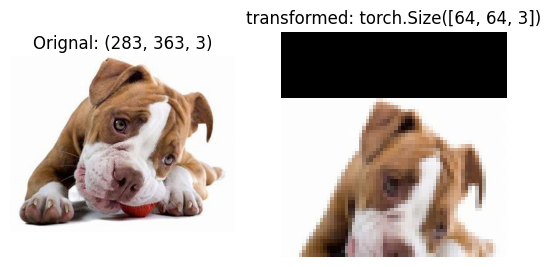

In [58]:
# lets visualize what the transforms do
torch.manual_seed(RANDOM_SEED)
def plot_images(path, transform=None, n_sample=3, seed=42):
    random.seed(seed)
    img_paths = random.sample(path, k=n_sample)
    for img_path in img_paths:
        with open(img_path, "rb") as f:

            image = Image.open(img_path)
            transformed_image = transform(image).permute(1, 2, 0)

            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(np.asarray(image))
            ax[0].set_title(f"Orignal: {np.asarray(image).shape}")
            ax[0].axis("off")

            ax[1].imshow(transformed_image)
            ax[1].set_title(f"transformed: {transformed_image.shape}")
            ax[1].axis("off")



plot_images(VALID_IMGS["dog"], transform=train_transforms)        
len(VALID_IMGS["goat"])

In [102]:
from torch.utils.data.dataloader import DataLoader
import os

BATCH_SIZE = 16

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(train_data.classes, train_data.class_to_idx)
print(train_dataloader.batch_size)

['cat', 'cow', 'dog', 'goat'] {'cat': 0, 'cow': 1, 'dog': 2, 'goat': 3}
16


In [67]:
train_data[0]

(tensor([[[0.6784, 0.6941, 0.6941,  ..., 0.7765, 0.7725, 0.7765],
          [0.6824, 0.6863, 0.6784,  ..., 0.7725, 0.7686, 0.7765],
          [0.6863, 0.6824, 0.6706,  ..., 0.7765, 0.7686, 0.7686],
          ...,
          [0.1098, 0.1098, 0.1412,  ..., 0.5098, 0.4902, 0.4706],
          [0.1216, 0.1176, 0.1529,  ..., 0.5020, 0.4902, 0.4784],
          [0.1255, 0.1412, 0.1529,  ..., 0.4941, 0.4863, 0.4784]],
 
         [[0.6667, 0.6824, 0.6824,  ..., 0.7529, 0.7608, 0.7765],
          [0.6706, 0.6745, 0.6667,  ..., 0.7412, 0.7569, 0.7686],
          [0.6745, 0.6667, 0.6588,  ..., 0.7412, 0.7529, 0.7608],
          ...,
          [0.0863, 0.0863, 0.1176,  ..., 0.3412, 0.3373, 0.3294],
          [0.0980, 0.0941, 0.1333,  ..., 0.3333, 0.3333, 0.3412],
          [0.1020, 0.1216, 0.1333,  ..., 0.3333, 0.3333, 0.3412]],
 
         [[0.6314, 0.6471, 0.6471,  ..., 0.7294, 0.7294, 0.7412],
          [0.6353, 0.6353, 0.6275,  ..., 0.7137, 0.7176, 0.7294],
          [0.6353, 0.6314, 0.6196,  ...,

As seen above the `ImageFolder` class arranges our data into classes and tensors.The images have been normalized i.e between 0 and 1,  the `dataloader` shuffles our data and arranges into batches to be fed into the models

2. DEFINING MODELS AND TRAINING

I. TinyVGG archictecture


In [68]:
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=4, bias=True)
  )
)

In [72]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[ 0.0840,  0.0416,  0.0465, -0.0450]])

Output prediction probabilities:
tensor([[0.2631, 0.2522, 0.2534, 0.2313]])

Output prediction label:
tensor([0])

Actual label:
2


The model is outputting random guesses since it hasn't been trained

Training

In [73]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    %pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Note: you may need to restart the kernel to use updated packages.


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [82]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_0.parameters(), lr=0.1) 




def train_step(model:nn.Module,
               optimizer:torch.optim.Optimizer,
               loss_fn:nn.Module,
               dataset):
    
    # setting the model to train mode
    model.train()

    train_acc, train_loss = 0, 0

    for batch,(X, y)in enumerate(dataset):
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=-1)
        acc = (torch.eq(y_pred, y).sum().item()) / len(y_pred)
        train_acc += acc

        # setting the optimizer to zero grad to reset the gradients calculated from previous batches
        optimizer.zero_grad()

        # calculating the gradients
        loss.backward()

        # performing the step
        optimizer.step()

    
    return train_loss/len(dataset), train_acc/len(dataset) 



# defining the evaluation step
def test_step(model:nn.Module,
              loss_fn:nn.Module,
              dataset):
    
    # setting it to evaluation mode
    model.eval()
    test_acc, test_loss = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataset):
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss

            y_pred = torch.argmax(torch.softmax(y_pred, dim=1), dim=-1)
            acc = (torch.eq(y_pred, y).sum().item()) / len(y_pred)
            test_acc += acc
    
    return test_loss/len(dataset), test_acc/len(dataset) 




# the wrapper function

from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataset=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataset=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results


    

In [103]:
results = train(model_0, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, epochs=50)


  2%|▏         | 1/50 [00:19<15:56, 19.51s/it]

Epoch: 1 | train_loss: 1.3888 | train_acc: 0.2778 | test_loss: 1.3799 | test_acc: 0.2778


  4%|▍         | 2/50 [00:38<15:19, 19.16s/it]

Epoch: 2 | train_loss: 1.3865 | train_acc: 0.2952 | test_loss: 1.3787 | test_acc: 0.2778


  6%|▌         | 3/50 [00:56<14:43, 18.80s/it]

Epoch: 3 | train_loss: 1.3860 | train_acc: 0.2938 | test_loss: 1.3881 | test_acc: 0.2778


  8%|▊         | 4/50 [01:15<14:19, 18.69s/it]

Epoch: 4 | train_loss: 1.3819 | train_acc: 0.2935 | test_loss: 1.3826 | test_acc: 0.2431


 10%|█         | 5/50 [01:33<13:57, 18.61s/it]

Epoch: 5 | train_loss: 1.3875 | train_acc: 0.2746 | test_loss: 1.3830 | test_acc: 0.2778


 12%|█▏        | 6/50 [01:52<13:41, 18.67s/it]

Epoch: 6 | train_loss: 1.3866 | train_acc: 0.2952 | test_loss: 1.3856 | test_acc: 0.2431


 14%|█▍        | 7/50 [02:11<13:21, 18.65s/it]

Epoch: 7 | train_loss: 1.3914 | train_acc: 0.2331 | test_loss: 1.3782 | test_acc: 0.2778


 16%|█▌        | 8/50 [02:29<12:58, 18.54s/it]

Epoch: 8 | train_loss: 1.3879 | train_acc: 0.2925 | test_loss: 1.3827 | test_acc: 0.2431


 18%|█▊        | 9/50 [02:49<13:02, 19.09s/it]

Epoch: 9 | train_loss: 1.3851 | train_acc: 0.2956 | test_loss: 1.3813 | test_acc: 0.2847


 20%|██        | 10/50 [03:08<12:33, 18.84s/it]

Epoch: 10 | train_loss: 1.3841 | train_acc: 0.2756 | test_loss: 1.3947 | test_acc: 0.2778


 22%|██▏       | 11/50 [03:26<12:07, 18.64s/it]

Epoch: 11 | train_loss: 1.3927 | train_acc: 0.2621 | test_loss: 1.3762 | test_acc: 0.2847


 24%|██▍       | 12/50 [03:44<11:42, 18.49s/it]

Epoch: 12 | train_loss: 1.3823 | train_acc: 0.2698 | test_loss: 1.3858 | test_acc: 0.2778


 26%|██▌       | 13/50 [04:02<11:24, 18.51s/it]

Epoch: 13 | train_loss: 1.3882 | train_acc: 0.2831 | test_loss: 1.3984 | test_acc: 0.2431


 28%|██▊       | 14/50 [04:22<11:13, 18.72s/it]

Epoch: 14 | train_loss: 1.3841 | train_acc: 0.3087 | test_loss: 1.3919 | test_acc: 0.2778


 30%|███       | 15/50 [04:40<10:52, 18.64s/it]

Epoch: 15 | train_loss: 1.3897 | train_acc: 0.2671 | test_loss: 1.3858 | test_acc: 0.2778


 32%|███▏      | 16/50 [04:59<10:35, 18.70s/it]

Epoch: 16 | train_loss: 1.3868 | train_acc: 0.2556 | test_loss: 1.3947 | test_acc: 0.2778


 34%|███▍      | 17/50 [05:19<10:26, 18.99s/it]

Epoch: 17 | train_loss: 1.3890 | train_acc: 0.2952 | test_loss: 1.3768 | test_acc: 0.2847


 36%|███▌      | 18/50 [05:37<10:01, 18.81s/it]

Epoch: 18 | train_loss: 1.3862 | train_acc: 0.2720 | test_loss: 1.3960 | test_acc: 0.2778


 38%|███▊      | 19/50 [05:56<09:43, 18.81s/it]

Epoch: 19 | train_loss: 1.4014 | train_acc: 0.2224 | test_loss: 1.3890 | test_acc: 0.2431


 40%|████      | 20/50 [06:14<09:19, 18.64s/it]

Epoch: 20 | train_loss: 1.3891 | train_acc: 0.2921 | test_loss: 1.3789 | test_acc: 0.2778


 42%|████▏     | 21/50 [06:33<09:01, 18.66s/it]

Epoch: 21 | train_loss: 1.3836 | train_acc: 0.2696 | test_loss: 1.3989 | test_acc: 0.2778


 44%|████▍     | 22/50 [06:52<08:43, 18.69s/it]

Epoch: 22 | train_loss: 1.3902 | train_acc: 0.2536 | test_loss: 1.3802 | test_acc: 0.2847


 46%|████▌     | 23/50 [07:10<08:23, 18.66s/it]

Epoch: 23 | train_loss: 1.3901 | train_acc: 0.2845 | test_loss: 1.3838 | test_acc: 0.2431


 48%|████▊     | 24/50 [07:29<08:03, 18.60s/it]

Epoch: 24 | train_loss: 1.3916 | train_acc: 0.2456 | test_loss: 1.3831 | test_acc: 0.2778


 50%|█████     | 25/50 [07:48<07:49, 18.76s/it]

Epoch: 25 | train_loss: 1.3878 | train_acc: 0.2917 | test_loss: 1.3886 | test_acc: 0.2431


 52%|█████▏    | 26/50 [08:06<07:27, 18.63s/it]

Epoch: 26 | train_loss: 1.3901 | train_acc: 0.2692 | test_loss: 1.3938 | test_acc: 0.2431


 54%|█████▍    | 27/50 [08:24<07:06, 18.55s/it]

Epoch: 27 | train_loss: 1.3893 | train_acc: 0.2889 | test_loss: 1.3890 | test_acc: 0.2431


 56%|█████▌    | 28/50 [08:44<06:53, 18.78s/it]

Epoch: 28 | train_loss: 1.3924 | train_acc: 0.2438 | test_loss: 1.3772 | test_acc: 0.2778


 58%|█████▊    | 29/50 [09:02<06:29, 18.53s/it]

Epoch: 29 | train_loss: 1.3850 | train_acc: 0.2952 | test_loss: 1.3801 | test_acc: 0.2778


 60%|██████    | 30/50 [09:20<06:06, 18.35s/it]

Epoch: 30 | train_loss: 1.3928 | train_acc: 0.2728 | test_loss: 1.3921 | test_acc: 0.2778


 62%|██████▏   | 31/50 [09:38<05:50, 18.45s/it]

Epoch: 31 | train_loss: 1.3956 | train_acc: 0.2444 | test_loss: 1.3841 | test_acc: 0.2778


 64%|██████▍   | 32/50 [09:56<05:29, 18.30s/it]

Epoch: 32 | train_loss: 1.3907 | train_acc: 0.2702 | test_loss: 1.3905 | test_acc: 0.2778


 66%|██████▌   | 33/50 [10:15<05:12, 18.38s/it]

Epoch: 33 | train_loss: 1.3888 | train_acc: 0.2831 | test_loss: 1.3871 | test_acc: 0.2431


 68%|██████▊   | 34/50 [10:32<04:50, 18.17s/it]

Epoch: 34 | train_loss: 1.3837 | train_acc: 0.2702 | test_loss: 1.3875 | test_acc: 0.2778


 70%|███████   | 35/50 [10:51<04:32, 18.16s/it]

Epoch: 35 | train_loss: 1.3852 | train_acc: 0.2925 | test_loss: 1.3812 | test_acc: 0.2778


 72%|███████▏  | 36/50 [11:09<04:13, 18.10s/it]

Epoch: 36 | train_loss: 1.3889 | train_acc: 0.3038 | test_loss: 1.3816 | test_acc: 0.2431


 74%|███████▍  | 37/50 [11:26<03:54, 18.05s/it]

Epoch: 37 | train_loss: 1.3832 | train_acc: 0.2756 | test_loss: 1.3883 | test_acc: 0.2778


 76%|███████▌  | 38/50 [11:44<03:34, 17.89s/it]

Epoch: 38 | train_loss: 1.3890 | train_acc: 0.2827 | test_loss: 1.3867 | test_acc: 0.2778


 78%|███████▊  | 39/50 [12:01<03:12, 17.53s/it]

Epoch: 39 | train_loss: 1.3922 | train_acc: 0.2952 | test_loss: 1.3940 | test_acc: 0.2431


 80%|████████  | 40/50 [12:17<02:50, 17.03s/it]

Epoch: 40 | train_loss: 1.3965 | train_acc: 0.2774 | test_loss: 1.3945 | test_acc: 0.2778


 82%|████████▏ | 41/50 [12:33<02:30, 16.73s/it]

Epoch: 41 | train_loss: 1.3940 | train_acc: 0.2653 | test_loss: 1.3968 | test_acc: 0.2778


 84%|████████▍ | 42/50 [12:49<02:12, 16.53s/it]

Epoch: 42 | train_loss: 1.3932 | train_acc: 0.2411 | test_loss: 1.3762 | test_acc: 0.2847


 86%|████████▌ | 43/50 [13:04<01:54, 16.31s/it]

Epoch: 43 | train_loss: 1.3922 | train_acc: 0.2875 | test_loss: 1.3781 | test_acc: 0.2778


 88%|████████▊ | 44/50 [13:21<01:37, 16.24s/it]

Epoch: 44 | train_loss: 1.3865 | train_acc: 0.2694 | test_loss: 1.3770 | test_acc: 0.2778


 90%|█████████ | 45/50 [13:36<01:20, 16.15s/it]

Epoch: 45 | train_loss: 1.3917 | train_acc: 0.2881 | test_loss: 1.3940 | test_acc: 0.2431


 92%|█████████▏| 46/50 [13:52<01:04, 16.09s/it]

Epoch: 46 | train_loss: 1.3919 | train_acc: 0.2567 | test_loss: 1.3824 | test_acc: 0.2431


 94%|█████████▍| 47/50 [14:08<00:47, 15.99s/it]

Epoch: 47 | train_loss: 1.3899 | train_acc: 0.2911 | test_loss: 1.3931 | test_acc: 0.2778


 96%|█████████▌| 48/50 [14:24<00:31, 15.95s/it]

Epoch: 48 | train_loss: 1.3964 | train_acc: 0.2389 | test_loss: 1.3989 | test_acc: 0.2778


 98%|█████████▊| 49/50 [14:40<00:15, 15.98s/it]

Epoch: 49 | train_loss: 1.3949 | train_acc: 0.2617 | test_loss: 1.3902 | test_acc: 0.2778


100%|██████████| 50/50 [14:56<00:00, 17.94s/it]

Epoch: 50 | train_loss: 1.3881 | train_acc: 0.2974 | test_loss: 1.4015 | test_acc: 0.2431


In [108]:
results

{'train_loss': [tensor(1.3888, grad_fn=<DivBackward0>),
  tensor(1.3865, grad_fn=<DivBackward0>),
  tensor(1.3860, grad_fn=<DivBackward0>),
  tensor(1.3819, grad_fn=<DivBackward0>),
  tensor(1.3875, grad_fn=<DivBackward0>),
  tensor(1.3866, grad_fn=<DivBackward0>),
  tensor(1.3914, grad_fn=<DivBackward0>),
  tensor(1.3879, grad_fn=<DivBackward0>),
  tensor(1.3851, grad_fn=<DivBackward0>),
  tensor(1.3841, grad_fn=<DivBackward0>),
  tensor(1.3927, grad_fn=<DivBackward0>),
  tensor(1.3823, grad_fn=<DivBackward0>),
  tensor(1.3882, grad_fn=<DivBackward0>),
  tensor(1.3841, grad_fn=<DivBackward0>),
  tensor(1.3897, grad_fn=<DivBackward0>),
  tensor(1.3868, grad_fn=<DivBackward0>),
  tensor(1.3890, grad_fn=<DivBackward0>),
  tensor(1.3862, grad_fn=<DivBackward0>),
  tensor(1.4014, grad_fn=<DivBackward0>),
  tensor(1.3891, grad_fn=<DivBackward0>),
  tensor(1.3836, grad_fn=<DivBackward0>),
  tensor(1.3902, grad_fn=<DivBackward0>),
  tensor(1.3901, grad_fn=<DivBackward0>),
  tensor(1.3916, gra

Text(0.5, 1.0, 'loss')

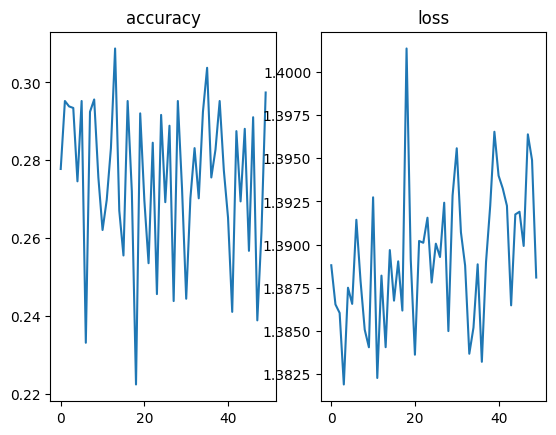

In [111]:
fig, ax = plt.subplots(1, 2)

losses = [res.item() for res in results["train_loss"]]
ax[0].plot(range(50), results["train_acc"])
ax[0].set_title("accuracy")


ax[1].plot(range(50), losses)
ax[1].set_title("loss")



TinyVGG is not really performing well
as seen from the graphs, accuracy and losses are stochastic; no convergence is occuring



2. Model1


In [95]:

class SmallVGG(nn.Module):
  
    
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*32*32,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_1 = SmallVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_1

SmallVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=4, bias=True)
  )
)

In [96]:
summary(model_1, input_size=[1, 3, 128, 128])
    

Layer (type:depth-idx)                   Output Shape              Param #
SmallVGG                                 [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 64, 64]           --
│    └─Conv2d: 2-1                       [1, 10, 128, 128]         280
│    └─ReLU: 2-2                         [1, 10, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 10, 128, 128]         910
│    └─ReLU: 2-4                         [1, 10, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 10, 64, 64]           --
├─Sequential: 1-2                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 10, 64, 64]           910
│    └─ReLU: 2-7                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 10, 64, 64]           910
│    └─ReLU: 2-9                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-10                   [1, 10, 32, 32]           --
├─Sequentia

In [98]:

train_transforms1 = transforms.Compose([
    # resizing the images
    transforms.Resize((128, 128)),

    # random augment
    transforms.TrivialAugmentWide(num_magnitude_bins=10),

    # trasnforming to tensor
    transforms.ToTensor()
])

test_transforms1 = transforms.Compose([
    # resize
    transforms.Resize((128, 128)),

    # to tensors
    transforms.ToTensor()
])


# loading the images to a dataloader
train_data1 = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms1, target_transform=None)
test_data1 = datasets.ImageFolder(root=TEST_DIR, transform=test_transforms1, target_transform=None)

train_dataloader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

test_dataloader1 = DataLoader(
    dataset=test_data1,
    batch_size=BATCH_SIZE,
    shuffle=False
)

results = train(model_1, train_dataloader=train_dataloader1, test_dataloader=test_dataloader1, loss_fn=loss_fn, optimizer=optimizer, epochs=50)


  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:23<19:12, 23.52s/it]

Epoch: 1 | train_loss: 1.3872 | train_acc: 0.2450 | test_loss: 1.3825 | test_acc: 0.3563


  4%|▍         | 2/50 [00:47<18:51, 23.56s/it]

Epoch: 2 | train_loss: 1.3870 | train_acc: 0.2450 | test_loss: 1.3825 | test_acc: 0.3563


  6%|▌         | 3/50 [01:09<18:00, 22.99s/it]

Epoch: 3 | train_loss: 1.3867 | train_acc: 0.2494 | test_loss: 1.3825 | test_acc: 0.3563


  8%|▊         | 4/50 [01:31<17:14, 22.49s/it]

Epoch: 4 | train_loss: 1.3869 | train_acc: 0.2494 | test_loss: 1.3825 | test_acc: 0.3563


 10%|█         | 5/50 [01:53<16:42, 22.28s/it]

Epoch: 5 | train_loss: 1.3873 | train_acc: 0.2450 | test_loss: 1.3825 | test_acc: 0.3563


 12%|█▏        | 6/50 [02:14<16:14, 22.15s/it]

Epoch: 6 | train_loss: 1.3877 | train_acc: 0.2405 | test_loss: 1.3825 | test_acc: 0.3563


 14%|█▍        | 7/50 [02:36<15:47, 22.03s/it]

Epoch: 7 | train_loss: 1.3866 | train_acc: 0.2494 | test_loss: 1.3825 | test_acc: 0.3563


 16%|█▌        | 8/50 [02:58<15:24, 22.02s/it]

Epoch: 8 | train_loss: 1.3874 | train_acc: 0.2405 | test_loss: 1.3825 | test_acc: 0.3563


 18%|█▊        | 9/50 [03:20<15:05, 22.10s/it]

Epoch: 9 | train_loss: 1.3870 | train_acc: 0.2450 | test_loss: 1.3825 | test_acc: 0.3563


 20%|██        | 10/50 [03:42<14:36, 21.91s/it]

Epoch: 10 | train_loss: 1.3874 | train_acc: 0.2405 | test_loss: 1.3825 | test_acc: 0.3563


 22%|██▏       | 11/50 [04:09<15:10, 23.34s/it]

Epoch: 11 | train_loss: 1.3871 | train_acc: 0.2450 | test_loss: 1.3825 | test_acc: 0.3563


 22%|██▏       | 11/50 [04:23<15:34, 23.97s/it]


KeyboardInterrupt: 